# EDA plots for thesis

In [1]:
# imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
import os
import gc
import cupy
import cudf
import yaml
from datetime import datetime
import sklearn
from tqdm.auto import tqdm

with open(os.path.join("..", "config.yaml")) as f:
    main_cfg = yaml.load(f, Loader=yaml.FullLoader)
    
with open(os.path.join("..", "src", "experiments", "configs", "experiment-config-alpha.yaml")) as f:
    amex_cfg = yaml.load(f, Loader=yaml.FullLoader)

with open(os.path.join("..", "src", "experiments", "configs", "experiment-config-beta.yaml")) as f:
    lob_cfg = yaml.load(f, Loader=yaml.FullLoader)
    


## Amex dataset

In [2]:
# TODO

## LOB dataset

In [94]:
from src.lib.lob_loader import get_wf_lob_loaders
from src.lib.lob_train_utils import lob_epoch_train_one_epoch, lob_evaluator
from src.models.adaptive_grunet import AdaptiveGRUNetLOB
from src.preprocessing.static_transformations import StandardScalerTimeSeries
from src.preprocessing.adaptive_transformations import DAIN_Layer, BiN_Layer
from src.preprocessing.normalizing_flows import EDAIN_Layer, EDAINScalerTimeSeries, EDAINScalerTimeSeriesDecorator


In [3]:
train_loader, val_loader = get_wf_lob_loaders(
    h5_path=lob_cfg['lob_dataset']['preprocessed_lob_path'],
    window=15,
    horizon=2,
    split=8,
    batch_size=128,
)

### Big model and optimizer cell

In [24]:
################################### local EDAIN ################################
edain_model = AdaptiveGRUNetLOB(
    adaptive_layer=EDAIN_Layer(
        input_dim=144,
        invert_bijector=False,
        outlier_removal_residual_connection=True,
        batch_aware=True,
        init_sigma=0.000001,
        outlier_removal_mode='exp',
    ),
    time_series_length=15,
    dim_first=False,
    input_dim=144,
)

edain_optimizer = torch.optim.RMSprop(
    edain_model.preprocess.get_optimizer_param_list(
        base_lr=1e-4,
        # For local-aware
        scale_lr=0.0001,
        shift_lr=0.01,
        outlier_lr=10.0,
        power_lr=0.1,
        # below for global-aware
        # scale_lr: 10.0
        # shift_lr: 10.0
        # outlier_lr: 0.000001
        # power_lr: 0.001
        # # below for EDAIN-KL
        # scale_lr: 0.0001
        # shift_lr: 0.01
        # outlier_lr: 10.0
        # power_lr: 0.001
    ) + [
        {'params' : edain_model.gru.parameters(), 'lr' : 1e-4},
        {'params' : edain_model.feed_forward.parameters(), 'lr' : 1e-4},
    ], lr=1e-4)

################################### global EDAIN ################################
edain_global_model = AdaptiveGRUNetLOB(
    adaptive_layer=EDAIN_Layer(
        input_dim=144,
        invert_bijector=False,
        outlier_removal_residual_connection=True,
        batch_aware=False,
        init_sigma=0.000001,
        outlier_removal_mode='exp',
    ),
    time_series_length=15,
    dim_first=False,
    input_dim=144,
)

edain_global_optimizer = torch.optim.RMSprop(
    edain_global_model.preprocess.get_optimizer_param_list(
        base_lr=1e-4,
        # For local-aware
        # scale_lr=0.0001,
        # shift_lr=0.01,
        # outlier_lr=10.0,
        # power_lr=0.1,
        # below for global-aware
        scale_lr=10.0,
        shift_lr=10.0,
        outlier_lr=0.000001,
        power_lr=0.001,
        # # below for EDAIN-KL
        # scale_lr: 0.0001
        # shift_lr: 0.01
        # outlier_lr: 10.0
        # power_lr: 0.001
    ) + [
        {'params' : edain_global_model.gru.parameters(), 'lr' : 1e-4},
        {'params' : edain_global_model.feed_forward.parameters(), 'lr' : 1e-4},
    ], lr=1e-4)

################################### DAIN ################################
dain_model = AdaptiveGRUNetLOB(
    adaptive_layer=DAIN_Layer(
        mode='adaptive_scale',
        input_dim=144,
        mean_lr=0.01,
        scale_lr=0.00000001,
        gate_lr=10,
    ),
    time_series_length=15,
    dim_first=True,
    input_dim=144,
)

dain_optimizer = torch.optim.RMSprop(
    dain_model.preprocess.get_optimizer_param_list(
        base_lr=1e-4,
    ) + [
        {'params' : dain_model.gru.parameters(), 'lr' : 1e-4},
        {'params' : dain_model.feed_forward.parameters(), 'lr' : 1e-4},
    ], lr=1e-4)

#################################### BIN ###############################
bin_model = AdaptiveGRUNetLOB(
    adaptive_layer=BiN_Layer(
        input_shape=(144, 15),
    ),
    time_series_length=15,
    dim_first=True,
    input_dim=144,
)

bin_optimizer = torch.optim.RMSprop(
    bin_model.preprocess.get_optimizer_param_list(
        base_lr=1e-4,
        beta_lr=1.0,
        gamma_lr=0.00000001,
        lambda_lr=0.1,
    ) + [
        {'params' : bin_model.gru.parameters(), 'lr' : 1e-4},
        {'params' : bin_model.feed_forward.parameters(), 'lr' : 1e-4},
    ], lr=1e-4)

Mode =  adaptive_scale


### Fit runner and loader cell

In [104]:
# fit the model
torch.multiprocessing.set_sharing_strategy('file_system')
np.random.seed(42)
torch.manual_seed(42)
DEV = torch.device('cuda', 5)

FIT_PREPROCESS = False
FIT_EDAIN = False
FIT_EDAIN_GLOBAL = False
FIT_BIN = False
FIT_DAIN = False
FIT_EDAIN_KL = False

if FIT_PREPROCESS:
    # fit the standard scaler first on the training data
    preprocess = StandardScalerTimeSeries(15)
    X_train = []
    y_train = []
    for X, y in tqdm(train_loader, desc="Preprocess"):
        X_train.append(X.numpy())
        y_train.append(y.numpy())
    X_train = np.concatenate(X_train, axis=0)
    y_train = np.concatenate(y_train, axis=0)
    print("Fitting standard scaler")
    X_train_ss = preprocess.fit_transform(X_train)
    print("Done!")

if FIT_EDAIN:
    edain_model = edain_model.to(DEV)
    for i in tqdm(range(20)):
        train_loss = lob_epoch_train_one_epoch(edain_model, train_loader, preprocess, edain_optimizer, DEV)
        print(f"Epoch {i+1}: Train loss = {train_loss:.8f}") 
    torch.save(edain_model.state_dict(), os.path.join(main_cfg['checkpoint_directory'], "edain_local-aware_lob"))
else:
    edain_model = edain_model.cpu()
    edain_model.load_state_dict(torch.load(os.path.join(main_cfg['checkpoint_directory'], "edain_local-aware_lob")))
    edain_model.eval()
    
if FIT_EDAIN_GLOBAL:
    edain_global_model = edain_global_model.to(DEV)
    for i in tqdm(range(20)):
        train_loss = lob_epoch_train_one_epoch(edain_global_model, train_loader, preprocess, edain_global_optimizer, DEV)
        print(f"Epoch {i+1}: Train loss = {train_loss:.8f}") 
    torch.save(edain_global_model.state_dict(), os.path.join(main_cfg['checkpoint_directory'], "edain_global-aware_lob"))
else:
    edain_global_model = edain_global_model.cpu()
    edain_global_model.load_state_dict(torch.load(os.path.join(main_cfg['checkpoint_directory'], "edain_global-aware_lob")))
    edain_global_model.eval()
    
if FIT_DAIN:
    dain_model = dain_model.to(DEV)
    for i in tqdm(range(20)):
        train_loss = lob_epoch_train_one_epoch(dain_model, train_loader, None, dain_optimizer, DEV)
        print(f"Epoch {i+1}: Train loss = {train_loss:.8f}") 
    torch.save(dain_model.state_dict(), os.path.join(main_cfg['checkpoint_directory'], "dain_lob"))
else:
    dain_model = dain_model.cpu()
    dain_model.load_state_dict(torch.load(os.path.join(main_cfg['checkpoint_directory'], "dain_lob")))
    dain_model.eval()
    
if FIT_BIN:
    bin_model = bin_model.to(DEV)
    for i in tqdm(range(20)):
        train_loss = lob_epoch_train_one_epoch(bin_model, train_loader, None, bin_optimizer, DEV)
        print(f"Epoch {i+1}: Train loss = {train_loss:.8f}") 
    torch.save(bin_model.state_dict(), os.path.join(main_cfg['checkpoint_directory'], "bin_lob"))
else:
    bin_model = bin_model.cpu()
    bin_model.load_state_dict(torch.load(os.path.join(main_cfg['checkpoint_directory'], "bin_lob")))
    bin_model.eval()
    
if True:
    edain_kl = EDAINScalerTimeSeriesDecorator(
        scaler=StandardScalerTimeSeries(15),
        time_series_length=15,
        input_dim=144,
        bijector_kwargs={
            'init_sigma' : 0.0001,
            'eps' : 0.00001,
            'batch_aware' : False,
            'outlier_removal_mode' : 'exp',
        },
        bijector_fit_kwargs={
            'device' : DEV,
            'scale_lr' : 0.0001,
            'shift_lr' : 0.01,
            'outlier_lr' : 10.0,
            'power_lr' : 0.01,
            'batch_size' : 1024,
            'milestones' : [3, 7],
            'num_epochs' : 8 if FIT_EDAIN_KL else 1,
            'num_fits' : 1,
            'base_lr': 1e-2,
        })
    if FIT_EDAIN_KL:
        X_train_edain_kl = edain_kl.fit_transform(X_train, y_train)
        torch.save(edain_kl.bijector.state_dict(), os.path.join(main_cfg['checkpoint_directory'], "edain-kl-bijector"))
    else:
        edain_kl.fit(X_train[:2000], y_train[:2000])
        edain_kl.bijector.load_state_dict(torch.load(os.path.join(main_cfg['checkpoint_directory'], "edain-kl-bijector")))
        edain_kl.bijector.eval()
        X_train_edain_kl = edain_kl.transform(X_train)

Fitting bijector:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Transforming data using bijector:   0%|          | 0/408 [00:00<?, ?it/s]

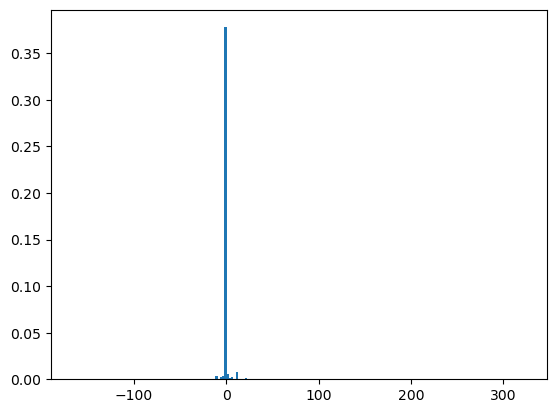

In [22]:
plt.hist(X_train[:, :, 90].reshape((-1, 1)), bins=200, density=True)
plt.show()

In [45]:
def transform_data(mod, dim_first=False, z_score=False):
    mod = mod.to(DEV)
    X_train_transformed = []
    for X, _ in tqdm(train_loader, desc="Transforming data"):
        if z_score:
            X = torch.tensor(preprocess.transform(X))
        X = X.to(DEV)
        if dim_first:
            X = X.transpose(1, 2)
        X_out = mod.preprocess(X)
        if dim_first:
            X_out = X_out.transpose(1, 2)
        X_train_transformed.append(X_out.detach().cpu().numpy())
    mod = mod.cpu()
    return np.concatenate(X_train_transformed, axis=0)


X_train_edain = transform_data(edain_model, z_score=True)
X_train_dain = transform_data(dain_model, dim_first=True)
X_train_bin = transform_data(bin_model, dim_first=True)
X_train_edain_global = transform_data(edain_global_model, z_score=True)

Transforming data:   0%|          | 0/3259 [00:00<?, ?it/s]

Transforming data:   0%|          | 0/3259 [00:00<?, ?it/s]

Transforming data:   0%|          | 0/3259 [00:00<?, ?it/s]

Transforming data:   0%|          | 0/3259 [00:00<?, ?it/s]

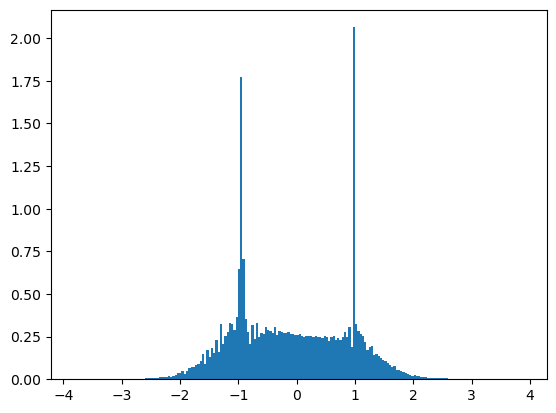

In [87]:
# Dims to use: 13, 90, and 50

plt.hist(X_train_edain[:, :, 50].reshape((-1, 1)), bins=200, density=True)
plt.show()

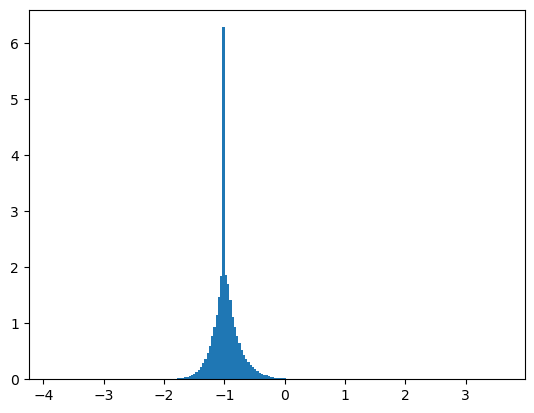

In [92]:
plt.hist(X_train_dain[:, :, 50].reshape((-1, 1)), bins=200, density=True)
plt.show()

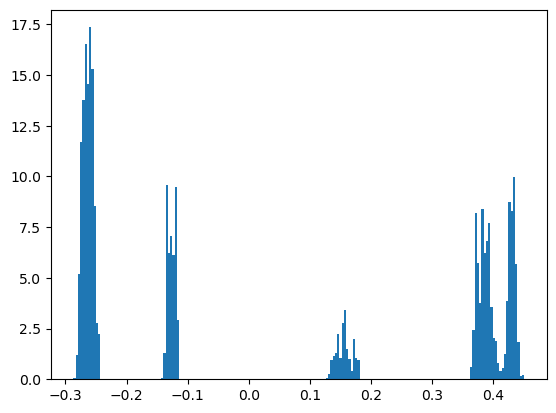

In [89]:
plt.hist(X_train_edain_global[:, :, 50].reshape((-1, 1)), bins=200, density=True)
plt.show()

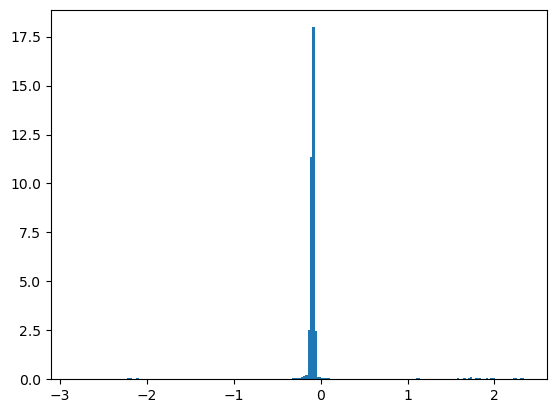

In [108]:
plt.hist(X_train_edain_kl[:, :, 90].reshape((-1, 1)), bins=200, density=True)
plt.show()

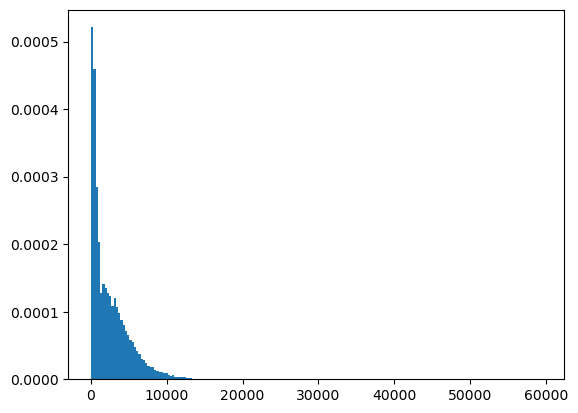

In [107]:
plt.hist(X_train[:, :, 13].reshape((-1, 1)), bins=200, density=True)
plt.show()

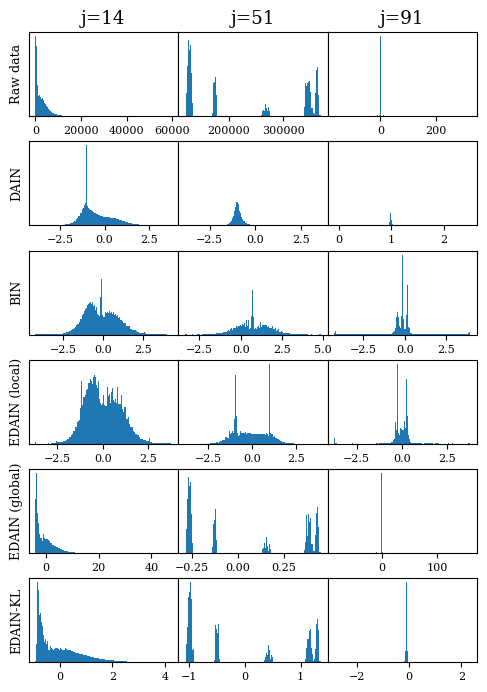

In [121]:
# below is full plotting code
# TODO: trian EDAIN-KL for longer so that more illustrative plots for it!
#       When doing this, can also add option for merging time and sample axis
#       so that can train for plots better with only D unknown params...
from src.lib.plotting import get_figsize, save_plot, update_plot_params

update_plot_params(**{"text.usetex":False})
get_figsize(height_width_ratio=np.sqrt(2))

methods = [X_train, X_train_dain, X_train_bin, X_train_edain, X_train_edain_global, X_train_edain_kl]
meth_names = ["Raw data", "DAIN", "BIN", "EDAIN (local)", "EDAIN (global)", "EDAIN-KL"]

fig, axs = plt.subplots(nrows=6, ncols=3, figsize=get_figsize(height_width_ratio=np.sqrt(2)))
# variable names
axs[0, 0].set_title("j=14")
axs[0, 1].set_title("j=51")
axs[0, 2].set_title("j=91")

# plot all the histograms
for i, (Xs, lab) in enumerate(zip(methods, meth_names)):
    axs[i, 0].set_ylabel(lab)
    for j in range(3):
        axs[i, j].set_yticks([])
    axs[i, 0].hist(Xs[:, :, 13].reshape((-1, 1)), bins=200, density=True)
    axs[i, 1].hist(Xs[:, :, 50].reshape((-1, 1)), bins=200, density=True)
    axs[i, 2].hist(Xs[:, :, 90].reshape((-1, 1)), bins=200, density=True)
plt.subplots_adjust(wspace=0, hspace=0.3)
save_plot(fig, "lob_example_transformations")